## Experiment: Using 3D measurements

**Strategy:**  The previous notebook only used magnitude of acceleration and actually did quite well (in my opinion).  But I believe that there may be even richer information in the 3D data.

Steps:

* Calculate acceleration-magnitude vector as in experiment 1.  Put this aside.
* For each Nx3 sample, calculate the _median_ value in each of x, y, and z dimensions.  This will estimate the direction of gravity if the person stopped walking.
* Calculation rotation matrix to rotate gravity vector towards -z (0,0,-1).  Rotate all vectors in sample with the rotation matrix
* For all points, calculate latitude and longitude of the vector projected on the unit sphere
* For all N latitudes, compute N-1 latitude differences/rotations, compute periodogram
* For all N longitudes, compute N-1 longitude differences/rotations, compute periodogram
* Concatenate magnitude, d_latitude, d_longitude periodograms
* Use same L2-based KNN as in experiment #1

In [3]:
import os
import sys

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import json
import sklearn
import time
from accel_utils import AccelUtils
from train_utils import TrainUtils

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import DistanceMetric

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
params = AccelUtils.read_params_file('params.json')
num_subj = params['num_subj']
max_resample_pts = params['max_resample_pts']
min_timesteps_per_sample = int(params['max_resample_pts'] * params['filt_min_timesteps_per_sample_ratio'])
per_user_all_data = AccelUtils.read_all_user_data(params['data_dir'], num_subj)
valid_windows_by_user = {}
for i in range(num_subj):
    df = per_user_all_data[i]
    valid_windows_by_user[i] = AccelUtils.extract_valid_time_windows_for_subj(
        df,
        params['window_size_sec'],
        min_timesteps_per_sample)

min_samples = params['filt_min_samples_per_subj']
counts = [len(valid_windows_by_user[i]) for i in range(num_subj)]
use_subjs = [i for i in range(num_subj) if counts[i] >= min_samples]
print(f'Keeping {len(use_subjs)} subjects {use_subjs}')

Params:
{
  "data_dir": "./user_data",
  "filt_avg_power": 2.0,
  "filt_dc_ratio": 0.7,
  "filt_power_ratio": 0.5,
  "filt_min_samples_per_subj": 8,
  "max_dt": 0.035,
  "filt_min_timesteps_per_sample_ratio": 0.9,
  "resample_dt": 0.03,
  "window_size_sec": 4.3,
  "num_subj": 22,
  "max_resample_pts": 139,
  "min_timesteps_per_sample": 125
}
Number of files/subjects: 22
Each sample will be 139 time steps
Keeping 16 subjects [0, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 19, 21]


### Compute extra two feature sets for each window sample

In [7]:
valid_windows_by_user[0][0].head()

,t,x_acc,y_acc,z_acc,mag_acc
700,21.51,-4.2495,12.149,-1.0760,12.915658
701,21.54,-3.6366,13.566,-1.1169,14.089311
702,21.57,-3.7865,13.866,-1.8796,14.496083
703,21.60,-3.3370,12.790,-3.5958,13.698520
704,21.63,-2.9829,10.038,-4.0589,11.230931


In [28]:
def rotation_matrix_a_onto_b(a, b):
    # Formula from https://math.stackexchange.com/a/476311
    v = np.cross(a, b)
    s = np.linalg.norm(v)
    c = np.dot(a, b)

    vx = np.array([
        [    0, -v[2],  v[1]],
        [ v[2],     0, -v[0]],
        [-v[1],  v[0],     0]
    ])

    rotation_matrix = np.eye(3) + vx + np.matmul(vx, vx) * (1 / (1+c))
    return rotation_matrix

def estimate_gravity_and_rotation_matrix(df_subj):
    grav_est = np.array([df_subj[col].mean() for col in ['x_acc', 'y_acc', 'z_acc']])

    grav_est = grav_est / np.linalg.norm(grav_est)
    grav_targ = np.array([0, 0, -1])

    rot_matrix = rotation_matrix_a_onto_b(grav_est, grav_targ)
    return rot_matrix, grav_est


In [29]:
rotm, grav_est = estimate_gravity_and_rotation_matrix(valid_windows_by_user[0][0])
print('Testing rotation...')
print('  Rotation matrix:\n', rotm)
print('  Gravity estimate:', grav_est)
print('  Rotated grav est:', [f'{v:.3f}' for v in rotm.dot(grav_est).tolist()])

Testing rotation...
  Rotation matrix:
 [[ 0.92429324  0.23847764 -0.29801079]
 [ 0.23847764  0.24879124  0.93873923]
 [ 0.29801079 -0.93873923  0.17308447]]
  Gravity estimate: [-0.29801079  0.93873923 -0.17308447]
  Rotated grav est: ['-0.000', '0.000', '-1.000']


In [40]:
def align_window_acc_to_gravity(subj_window_df):
    rot_mtrx, _ = estimate_gravity_and_rotation_matrix(subj_window_df)
    xyz_vals = subj_window_df[['x_acc', 'y_acc', 'z_acc']].values
    rotated_vals = rot_mtrx.dot(xyz_vals.T).T
    #print(xyz_vals)
    print(rotated_vals)
    print(np.sum(rotated_vals, axis=0))
    subj_window_df['x_rot'] = rotated_vals[:, 0]
    subj_window_df['y_rot'] = rotated_vals[:, 1]
    subj_window_df['z_rot'] = rotated_vals[:, 2]

align_window_acc_to_gravity(valid_windows_by_user[0][0])
valid_windows_by_user[0][0].head()

[[-7.09859666e-01  9.99070615e-01 -1.28573786e+01]
 [ 2.06751114e-01  1.45937631e+00 -1.40120004e+01]
 [ 3.67035677e-01  7.82289475e-01 -1.44703055e+01]
 [ 1.03734966e+00 -9.89278459e-01 -1.36233139e+01]
 [ 8.46360228e-01 -2.02423715e+00 -1.10145333e+01]
 [ 7.92966036e-02 -2.53271902e+00 -1.02851863e+01]
 [-1.64343292e+00 -3.01467214e+00 -1.15034567e+01]
 [-3.26803971e+00 -1.96895946e+00 -1.15519986e+01]
 [-2.41249588e+00 -1.05975783e+00 -9.26549625e+00]
 [-3.69373374e-01 -1.06071082e+00 -7.23777451e+00]
 [ 1.17992789e+00 -7.19624638e-01 -6.42015345e+00]
 [ 8.25708223e-01  1.38698605e+00 -5.86469269e+00]
 [-1.03050248e+00  3.99784909e+00 -5.12199963e+00]
 [-2.38975432e-01  1.12742044e+00 -5.18833967e+00]
 [ 5.00067993e-01 -7.36912283e-01 -7.49695132e+00]
 [-2.62282487e-01 -5.53578593e-01 -9.80386645e+00]
 [-2.11995606e+00 -1.23977230e+00 -1.17199817e+01]
 [-4.00642220e+00  1.03056452e+00 -1.33530658e+01]
 [-2.74017052e+00  1.67710410e+00 -1.40499302e+01]
 [-9.72680928e-01 -7.85391932e-

,t,x_acc,y_acc,z_acc,mag_acc,x_rot,y_rot,z_rot
700,21.51,-4.2495,12.149,-1.0760,12.915658,-0.709860,0.999071,-12.857379
701,21.54,-3.6366,13.566,-1.1169,14.089311,0.206751,1.459376,-14.012000
702,21.57,-3.7865,13.866,-1.8796,14.496083,0.367036,0.782289,-14.470306
703,21.60,-3.3370,12.790,-3.5958,13.698520,1.037350,-0.989278,-13.623314
704,21.63,-2.9829,10.038,-4.0589,11.230931,0.846360,-2.024237,-11.014533


Total Row Count: 822


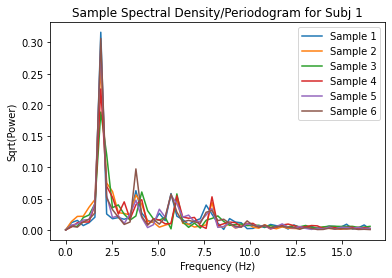

In [64]:
all_rows = []
fig,ax = plt.subplots()
for i_subj in use_subjs:
    for i_win, window in enumerate(valid_windows_by_user[i_subj]):
        fs, pow_norm = AccelUtils.compute_periodogram(
            window,
            params['resample_dt'],
            max_resample_pts)

        if len(pow_norm.tolist()) < max_resample_pts//2:
            continue

        all_rows.append(pow_norm.tolist() + [i_subj])
        
        # Display the first 6 periodograms for subj 0
        if i_subj==0 and i_win < 6:
            ax.plot(fs, pow_norm)
            
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Sqrt(Power)')
ax.set_title(f'Sample Spectral Density/Periodogram for Subj 1')
ax.legend([f'Sample {i+1}' for i in range(6)])
col_headers = [f'f{freq:.1f}' for freq in fs] + ['label']
print('Total Row Count:', len(all_rows))

That looks pretty consistent...

### Some standard data cleaning
Make sure labels are integers, remove any NA values

In [65]:
full_df = pd.DataFrame.from_records(all_rows, columns=col_headers)
full_df.dropna(axis=0, inplace=True)
full_df['label'] = full_df['label'].astype('int32')
print('Total dataset size:', full_df.shape)
full_df.head(5)

Total dataset size: (821, 54)


,f0.0,f0.3,f0.6,f1.0,f1.3,f1.6,f1.9,f2.2,f2.5,f2.9,...,f14.0,f14.3,f14.6,f14.9,f15.2,f15.6,f15.9,f16.2,f16.5,label
0,9.329974e-17,0.011751,0.015216,0.006946,0.011603,0.020414,0.316335,0.025533,0.017898,0.019702,...,0.003602,0.006014,0.005403,0.004400,0.009112,0.001425,0.003394,0.007931,0.001247,0
1,5.734859e-18,0.013474,0.021621,0.021835,0.036426,0.048618,0.261210,0.075006,0.061521,0.027660,...,0.004654,0.002314,0.002058,0.001162,0.001895,0.002662,0.004251,0.002553,0.001979,0
2,3.112368e-17,0.006439,0.005662,0.019757,0.023905,0.041672,0.188669,0.120842,0.035547,0.040071,...,0.004728,0.005950,0.005806,0.005533,0.005666,0.005690,0.003975,0.004498,0.005709,0
3,9.287545e-17,0.004727,0.011481,0.012555,0.012698,0.040290,0.225607,0.069966,0.052186,0.025233,...,0.002156,0.004056,0.003663,0.001842,0.004005,0.004266,0.001401,0.003761,0.002215,0
4,9.640622e-17,0.007816,0.009553,0.015796,0.016530,0.042848,0.291812,0.054968,0.019755,0.022763,...,0.001659,0.004491,0.001305,0.004241,0.003968,0.002331,0.004048,0.002189,0.002704,0


------

## Split the Data into Test and Train Sets
We use sklearn's StratifiedKFold to make sure we get proportional representation of all classes in both test and train sets

In [66]:
num_splits = 5
for i in range(num_splits):
    xt,yt,xs,ys = TrainUtils.get_skf_split(full_df, num_splits, i)
    print(f'Shapes: '
          f'Train: X ~ {xt.shape}, y ~ {yt.shape}  '
          f'Test : X ~ {xs.shape}, y ~ {ys.shape}')

Shapes: Train: X ~ (656, 53), y ~ (656,)  Test : X ~ (165, 53), y ~ (165,)
Shapes: Train: X ~ (657, 53), y ~ (657,)  Test : X ~ (164, 53), y ~ (164,)
Shapes: Train: X ~ (657, 53), y ~ (657,)  Test : X ~ (164, 53), y ~ (164,)
Shapes: Train: X ~ (657, 53), y ~ (657,)  Test : X ~ (164, 53), y ~ (164,)
Shapes: Train: X ~ (657, 53), y ~ (657,)  Test : X ~ (164, 53), y ~ (164,)


### Normalize Input Features
We use sklearn's standard scaler.

NOTE: We switched to purely periodogram-based features, we probably don't want to normalize them...

In [78]:
# We do this if we had std features, but these are periodograms, I don't think it makes sense
_ = """
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# We can pickle the scaler to disk to save for later
import pickle
with open('xdata_scaler.pickle', 'wb') as f:
    pickle.dump(scaler, f)
"""


### Distance Metric Experiment
We need a way to compare periodograms for a KNN classifier.  L2 distance is the default KNN distance metric, which can be our baseline.  KL-Divergence is used for probability distributions and is not symmetric, but seems to have good properties for our application (if we scale our periodogram to sum to 1 like a probibilty density).

So we will try 4 ways to make KL-divergence symmetric and compare it to the default L2 metric

In [68]:
def kl_divergence(a, b):
    valid = a != 0
    return np.sum(a[valid] * np.log(a[valid] / (b[valid] + 1e-8)))

# Make a symmetric distance metric based on KL-divergence-based
def distance_kldiv(y1, y2, pool_method):
    
    # We can create symmetry by computing KL divergence both ways and pooling
    kl1 =  kl_divergence(y1, y2) + 1e-8
    kl2 =  kl_divergence(y2, y1) + 1e-8
    
    if pool_method == 'min':
        return min(kl1, kl2)
    elif pool_method == 'max':
        return max(kl1, kl2)
    elif pool_method == 'sum':
        return kl1 + kl2
    elif pool_method == 'geom':
        return 1.0 / (1.0/kl1 + 1.0/kl2)
    
   

### Create Classifier and Train
"Training" is a funny word to use with KNN -- you just add all the training samples to a list...

In [69]:
for kltype in ['L2', 'min', 'max', 'sum', 'geom']:
    tstart = time.time()
    if kltype in [None, 'L2']:
        # Regular L2 distance
        knn = KNeighborsClassifier(n_neighbors=1)
    else:
        # Try one of the 
        dist_func = lambda a,b: distance_kldiv(a, b, kltype)
        knn = KNeighborsClassifier(n_neighbors=1, metric=dist_func)
                
    y_true_agg, y_pred_agg = TrainUtils.kfold_train_predict(knn, full_df, num_splits=5)
    telapsed = time.time() - tstart
    acc = sklearn.metrics.accuracy_score(y_true_agg, y_pred_agg)
    print('Metric:', kltype.ljust(5), f'Acc: {acc:.4f} ({telapsed:.2f} sec)')


Metric: L2    Acc: 0.6005 (0.04 sec)
Metric: min   Acc: 0.5554 (8.28 sec)
Metric: max   Acc: 0.5384 (8.55 sec)
Metric: sum   Acc: 0.5432 (8.40 sec)
Metric: geom  Acc: 0.5469 (8.51 sec)


## Hmmm...
It really looks like none of the KL-divergence options were worth the trouble.  And they're waaaay slower (not sure how much it has to do with the KL-div calc itself vs using custom distance metric with KNN, which was mentioned in the sklearn docs).

My guess is that KL-divergence cares too much about non-dominant frequencies, whereas L2 distance is most heavily influenced by the dominant frequencies.

------

Let's look at the classification report for one model using the default L2 distance.  

In [70]:
knn = KNeighborsClassifier(n_neighbors=1)
y_true_agg, y_pred_agg = TrainUtils.kfold_train_predict(knn, full_df, num_splits=5)
print(sklearn.metrics.classification_report(y_true_agg, y_pred_agg))

              precision    recall  f1-score   support

           0       0.69      0.85      0.76        34
           3       0.59      0.58      0.59        38
           5       0.57      0.24      0.34        33
           6       0.40      0.20      0.27        20
           7       0.20      0.18      0.19        17
           8       0.24      0.27      0.26        33
           9       0.35      0.50      0.41        26
          10       0.42      0.55      0.48        38
          11       0.29      0.23      0.26        30
          12       0.52      0.64      0.57        44
          13       0.41      0.29      0.34        38
          14       0.73      0.88      0.80        25
          16       0.77      0.76      0.77       125
          17       0.62      0.68      0.65       122
          19       0.78      0.79      0.78       137
          21       0.61      0.49      0.55        61

    accuracy                           0.60       821
   macro avg       0.51   

Confusion Matrix


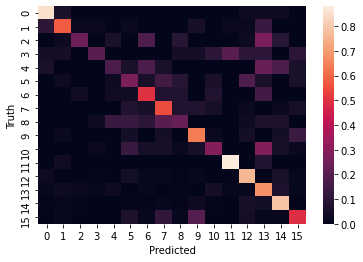

In [71]:
fig,ax = plt.subplots()
ax = sns.heatmap(sklearn.metrics.confusion_matrix(y_true_agg, y_pred_agg, labels=use_subjs, normalize='true'), ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Truth')
print('Confusion Matrix')

fig.savefig('confusion_matrix.png')

Confusion Matrix isn't all that exciting...

-----

-----

### Hyperparameter search
Define a single, parameterized, end-to-end dataset-preprocessing-splitting-training method.

In [72]:
try:
    import GPyOpt
    from GPyOpt.methods import BayesianOptimization
except:
    print('GPyOpt module not installed.  Remainder of notebook cannot be run without it')
    print('It can easily be installed via "pip install gpyopt"')
    raise
    
# This only needs to be loaded from file once
params = AccelUtils.read_params_file('params.json')
num_subj = params['num_subj']
per_user_all_data = AccelUtils.read_all_user_data(params['data_dir'], num_subj)
global_results = []  # List((num_subj, accuracy, params))

# Parameterized training method, mostly with copied fragments from the rest of the notebook
def parameterized_train(hyperparams):
    max_resample_pts = hyperparams['max_resample_pts']
    n_subj = hyperparams['num_subj']
    min_samples = hyperparams['filt_min_samples_per_subj']
    min_timesteps_per_sample = int(hyperparams['max_resample_pts'] *
                                   hyperparams['filt_min_timesteps_per_sample_ratio'])

    valid_windows_by_user = {}
    for i in range(n_subj):
        df = per_user_all_data[i]
        valid_windows_by_user[i] = AccelUtils.extract_valid_time_windows_for_subj(
            df,
            hyperparams['window_size_sec'],
            min_timesteps_per_sample)

    counts = [len(valid_windows_by_user[i]) for i in range(n_subj)]
    use_subjs = [i for i in range(n_subj) if counts[i] >= min_samples]

    all_rows = []
    for i_subj in use_subjs:
        for i_win, window in enumerate(valid_windows_by_user[i_subj]):
            fs, pow_norm = AccelUtils.compute_periodogram(
                window,
                hyperparams['resample_dt'],
                max_resample_pts)

            if len(pow_norm.tolist()) < max_resample_pts//2:
                continue

            all_rows.append(pow_norm.tolist() + [i_subj])

    col_headers = [f'freq_{i:02d}' for i in range(len(all_rows[0]))]
    col_headers[-1] = 'label'
    full_df = pd.DataFrame.from_records(all_rows, columns=col_headers)
    full_df.dropna(axis=0, inplace=True)
    full_df['label'] = full_df['label'].astype('int32')

    knn = KNeighborsClassifier(n_neighbors=1)
    y_true_agg, y_pred_agg = TrainUtils.kfold_train_predict(knn, full_df, num_splits=5)
    acc = sklearn.metrics.accuracy_score(y_true_agg, y_pred_agg)

    global_results.append((len(use_subjs), acc, hyperparams))
    return acc

print(f'Accuracy: {parameterized_train(params):.3f}')
print(f'Results List:', global_results)


Params:
{
  "data_dir": "./user_data",
  "filt_avg_power": 2.0,
  "filt_dc_ratio": 0.7,
  "filt_power_ratio": 0.5,
  "filt_min_samples_per_subj": 8,
  "max_dt": 0.035,
  "filt_min_timesteps_per_sample_ratio": 0.9,
  "resample_dt": 0.03,
  "window_size_sec": 3.3,
  "num_subj": 22,
  "max_resample_pts": 105,
  "min_timesteps_per_sample": 94
}
Number of files/subjects: 22
Each sample will be 105 time steps
Accuracy: 0.600
Results List: [(16, 0.6004872107186358, {'data_dir': './user_data', 'filt_avg_power': 2.0, 'filt_dc_ratio': 0.7, 'filt_power_ratio': 0.5, 'filt_min_samples_per_subj': 8, 'max_dt': 0.035, 'filt_min_timesteps_per_sample_ratio': 0.9, 'resample_dt': 0.03, 'window_size_sec': 3.3, 'num_subj': 22, 'max_resample_pts': 105, 'min_timesteps_per_sample': 94})]


### A quick grid search over just window size
I'll do the full parameter search with GPyOpt after this

In [ ]:
default_params = params.copy()
def eval_with_params(hyperparams):
    print(hyperparams)
    test_params = default_params.copy()
    test_params.update(hyperparams)
    AccelUtils.recompute_dervied_params(test_params)

    acc = parameterized_train(test_params)
    nsubj = global_results[-1][0]
    return acc


global_results = []
for w in np.arange(2.0, 6.0, step=0.1):
    upd_params = {'window_size_sec': w}
    acc = eval_with_params(upd_params)
    nsubj = global_results[-1][0]
    print(f'Tested window size={w:.1f}, accuracy: {acc:.3f} (#subj={nsubj})')

{'window_size_sec': 2.0}
Tested window size=2.0, accuracy: 0.522 (#subj=20)
{'window_size_sec': 2.1}
Tested window size=2.1, accuracy: 0.487 (#subj=20)
{'window_size_sec': 2.2}
Tested window size=2.2, accuracy: 0.519 (#subj=19)
{'window_size_sec': 2.3000000000000003}
Tested window size=2.3, accuracy: 0.557 (#subj=20)
{'window_size_sec': 2.4000000000000004}
Tested window size=2.4, accuracy: 0.543 (#subj=19)
{'window_size_sec': 2.5000000000000004}
Tested window size=2.5, accuracy: 0.540 (#subj=18)
{'window_size_sec': 2.6000000000000005}
Tested window size=2.6, accuracy: 0.550 (#subj=18)
{'window_size_sec': 2.7000000000000006}
Tested window size=2.7, accuracy: 0.563 (#subj=18)
{'window_size_sec': 2.8000000000000007}
Tested window size=2.8, accuracy: 0.566 (#subj=19)
{'window_size_sec': 2.900000000000001}
Tested window size=2.9, accuracy: 0.566 (#subj=18)
{'window_size_sec': 3.000000000000001}
Tested window size=3.0, accuracy: 0.541 (#subj=19)
{'window_size_sec': 3.100000000000001}
Tested 

In [ ]:
fig, ax = plt.subplots()
windows = [p['window_size_sec'] for _, _, p in global_results]
accs = [acc for _, acc, _ in global_results]
ax.plot(windows, accs)
ax.set_xlabel('Time Window Size (sec)')
ax.set_ylabel('Accuracy (5-fold cross val)')
ax.set_title('Accuracy as a function of time window')


In [ ]:
# GPyOpt seems to only be willing to pass tuples, not dictionaries... annoying
# So create yet another wrapper...
def create_eval_with_params_tuple(domain):
    kwarg_names = [var_dict['name'] for var_dict in domain]

    def out_func(param_tuple):
        kwargs = {}
        for i,v in enumerate(param_tuple[0]):
            kwargs[kwarg_names[i]] = v

        acc = eval_with_params(kwargs)
        print(acc)
        return -acc

    return out_func


In [ ]:
domain = [
  {'name': 'filt_avg_power',   'type': 'continuous', 'domain': (1.0, 3.0)},
  #{'name': "filt_dc_ratio",    'type': 'continuous', 'domain': (0.5, 1.0)},
  #{'name': "filt_power_ratio", 'type': 'continuous', 'domain': (0.5, 1.0)},
  {'name': "window_size_sec",  'type': 'continuous', 'domain': (2.0, 6.0)},
]

myBopt = BayesianOptimization(f=create_eval_with_params_tuple(domain), domain=domain)
myBopt.run_optimization(max_iter=100)
myBopt.plot_acquisition()

In [ ]:
myBopt.save_report('report.txt')

